## Debugging tanDip 

See https://github.com/Mu2e/EventNtuple/issues/287 

In [1]:
tag = "debug"

In [2]:
import uproot
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")
import numpy as np
import hist
import gc
import sys
from datetime import datetime

from pyutils.pyprocess import Processor, Skeleton
from pyutils.pyplot import Plot
from pyutils.pyprint import Print
from pyutils.pyselect import Select
from pyutils.pyvector import Vector

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse, Utils
from postprocess import PostProcess

# Process data

In [3]:
# from postprocess import PostProcesss

In [4]:
# Create your custom processor class
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self, file_name=None, file_list_path=None, defname=None, location=None):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class"s __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        self.file_name = file_name 
        self.defname = defname
        self.file_list_path = file_list_path
        
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits",
                "crvcoincs.pos.fCoordinates.fZ"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True     # Use remote file via mdh
        self.location = location   # File location
        self.max_workers = 50      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(
            # event_subrun=(93561, 25833), # select one event
            on_spill=True,
            verbosity=0
        )

        # Toggle cuts

        self.cuts_to_toggle = {
            "is_truth_electron" : True,
            "is_reco_electron" : True,
            "one_reco_electron" : True,
            "downstream" : True,
            "good_trkqual" : True,
            "has_hits" : False,
            "within_lhr_max" : False,
            "within_d0" : False,
            "within_t0" : True,
            "within_pitch_angle" : False,
            "unvetoed" : False
        }

        self.veto = False # a bit ugly 
            
        # Custom prefix for log messages from this processor
        self.print_prefix = "[CosmicProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class"s process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(
                this_data, 
                file_name,
                cuts_to_toggle = self.cuts_to_toggle
            )

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None

In [5]:
# Execute analysis
cosmic_processor = CosmicProcessor(
    # file_name="/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/data/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001202_00012335.root",
    # defname = "nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.root",
    file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.0_99.txt",
    location = "disk"
)
    
onspill_results = cosmic_processor.execute()

cosmic_processor = CosmicProcessor(
    # file_name="/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/data/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000699.root",
    # defname = "nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.root",
    file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt",
    location = "tape"
)
    
signal_results = cosmic_processor.execute()

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyutils] ⭐️ Setting up...
[pyutils] ✅ Ready
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 50 processes


Processing: 100%|██████████████████████████████| 100/100 [00:45<00:00,  2.20file/s, successful=100, failed=0]


[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = tape
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 50 processes


Processing: 100%|██████████████████████████████| 100/100 [00:45<00:00,  2.20file/s, successful=100, failed=0]

[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete


In [6]:
# Initialise postprocessor 
postprocessor = PostProcess()

# Execute postprocessor
data_onspill, _, stats_onspill, _ = postprocessor.execute(onspill_results)
data_signal, _, stats_signal, _ = postprocessor.execute(signal_results)

[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 11449 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[PostProcess] ✅ Combined arrays, result contains 57022 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats


In [7]:
print(len(data_onspill))
print(len(data_signal))

11449
57022


In [8]:
cut_manager = CutManager()
df_stats_onspill = cut_manager.get_cut_stats(stats=stats_onspill, active_only=True, printout=False)
df_stats_signal = cut_manager.get_cut_stats(stats=stats_signal, active_only=True, printout=False)

[CutManager] ✅ Created cut statistics DataFrame 
[CutManager] ✅ Created cut statistics DataFrame 


In [9]:
display(df_stats_onspill)

,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,267495,100.00,100.00,No selection applied
1,is_reco_electron,True,258586,96.67,96.67,Electron track fits
2,has_trk_front,True,256419,95.86,99.16,Tracks intersect tracker entrance
3,good_trkqual,True,45137,16.87,17.60,Track fit quality > 0.8)
4,within_t0,True,36789,13.75,81.51,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,downstream,True,26331,9.84,71.57,Downstream tracks (p_z > 0 at tracker entrance)
6,is_truth_electron,True,17328,6.48,65.81,Track parents are electrons (truth PID)
7,one_reco_electron,True,11449,4.28,66.07,One reco electron / event


In [10]:
# display(df_stats_onspill)
display(df_stats_signal)

,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,147342,100.00,100.00,No selection applied
1,is_reco_electron,True,147225,99.92,99.92,Electron track fits
2,has_trk_front,True,144742,98.24,98.31,Tracks intersect tracker entrance
3,good_trkqual,True,79107,53.69,54.65,Track fit quality > 0.8)
4,within_t0,True,57217,38.83,72.33,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,downstream,True,57217,38.83,100.00,Downstream tracks (p_z > 0 at tracker entrance)
6,is_truth_electron,True,57217,38.83,100.00,Track parents are electrons (truth PID)
7,one_reco_electron,True,57022,38.70,99.66,One reco electron / event


In [11]:
print(len(data_onspill))
print(len(data_signal))

onspill = ak.copy(data_onspill)
signal = ak.copy(data_signal)

11449
57022


## surface cut 

In [12]:
# data_onspill["trkfit"]

In [13]:
selector = Select()

# ST_Front = 100, ST_Back, ST_Inner, ST_Outer, ST_Foils, ST_Wires
# // 100–105

def apply_trk_ent_cut(data): 

    this_data = ak.copy(data)
    
    # Track front 
    at_trk_front = selector.select_surface(this_data["trkfit"], sid=0) # trksegs-level
    has_trk_front = ak.any(at_trk_front, axis=-1)

    this_data["trkfit"] = this_data["trkfit"][at_trk_front]
    
    # # Then clean up events with no tracks after cuts
    this_data = this_data[ak.any(has_trk_front, axis=-1)]

    print("Done")

    return this_data

def apply_ST_cut(data): 

    this_data = ak.copy(data)

    sid = this_data["trkfit"]["trksegs"]["sid"]
    
    # Trksegs 
    at_ST = (100 <= sid) & (sid <= 105)
    this_data["trkfit"] = this_data["trkfit"][at_ST]

    # Trk
    has_ST = ak.any(at_ST, axis=-1)

    # Clean up
    this_data = this_data[ak.any(has_ST, axis=-1)]

    print("Done")

    return this_data


onspill = apply_trk_ent_cut(data_onspill)
signal = apply_trk_ent_cut(data_signal)

onspill_at_ST = apply_ST_cut(data_onspill)
signal_at_ST = apply_ST_cut(data_signal)

[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done
Done
Done


## Calculate tanDip from momentum components

In [14]:
vector = Vector()

def calc_pitch_angle(data):

    pvec = vector.get_vector(data["trkfit"]["trksegs"], "mom")
    pt = np.sqrt(pvec["x"]**2 + pvec["y"]**2) # vector.get_vector(signal["trkfit"]["trksegs"], "mom")
    
    p = vector.get_mag(data["trkfit"]["trksegs"], "mom") 
    pz = data["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"]

    cos_theta = pt / p  
    theta = np.arccos(cos_theta)
    tan_theta_check = np.tan(theta)

    tan_theta = pz/pt 

    data["tan_dip"] = tan_theta
    # data["tan_theta_check"] = tan_theta_check

calc_pitch_angle(signal)
calc_pitch_angle(onspill)

[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


## Plot

In [15]:
plot = Plot()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## tanDip

[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] ✅ Returning mask for upstream track segments (p_z < 0)
[pyselect] ✅ Returning mask for downstream track segments (p_z > 0)
[pyselect] ✅ Returning mask for reflected tracks
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] ✅ Returning mask for upstream track segments (p_z < 0)
[pyselect] ✅ Returning mask for downstream track segments (p_z > 0)
[pyselect] ✅ Returning mask for reflected tracks


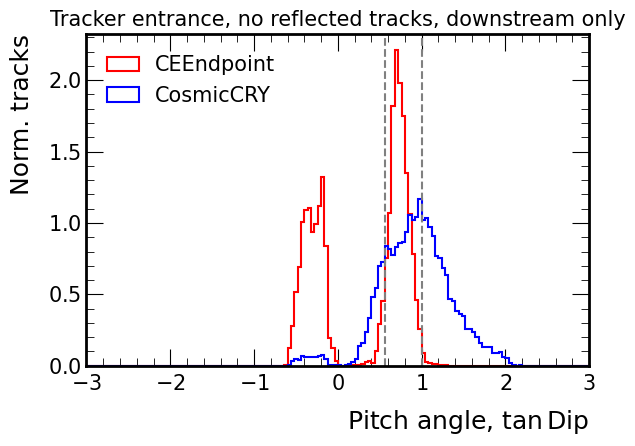

Wrote ../../img/comp/h1o_tandip_debug.png


In [16]:
fig, ax = plt.subplots()

is_reflected_signal = selector.is_reflected(signal["trkfit"])
is_reflected_onspill = selector.is_reflected(onspill["trkfit"])

plot.plot_1D_overlay(
    {
        # "CEEndpoint" : ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        # "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
        "CEEndpoint" : ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None)
    },
    nbins=150,xmin=-3,xmax=3,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax,
    title="Tracker entrance, no reflected tracks, downstream only",
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
    ylabel="Norm. tracks"
)


ax.axvline(0.5577350, linestyle="--", color="grey")
ax.axvline(1.0, linestyle="--", color="grey")
plt.tight_layout()
out_path = f"../../img/comp/h1o_tandip_{tag}.png"
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Wrote {out_path}")

[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] ✅ Returning mask for upstream track segments (p_z < 0)
[pyselect] ✅ Returning mask for downstream track segments (p_z > 0)
[pyselect] ✅ Returning mask for reflected tracks
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] ✅ Returning mask for upstream track segments (p_z < 0)
[pyselect] ✅ Returning mask for downstream track segments (p_z > 0)
[pyselect] ✅ Returning mask for reflected tracks


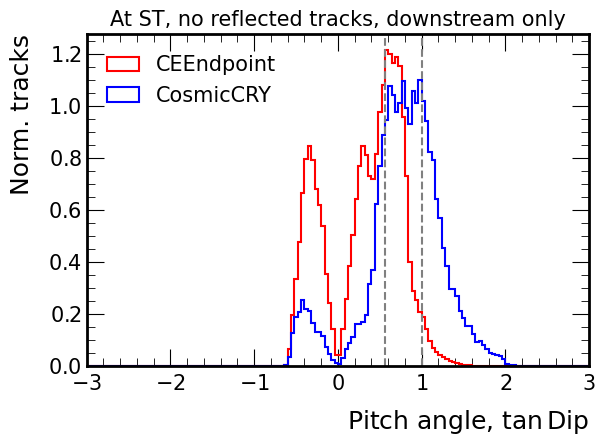

Wrote ../../img/comp/h1o_tandip_debug_at_ST.png


In [17]:
fig, ax = plt.subplots()

is_reflected_signal = selector.is_reflected(signal_at_ST["trkfit"])
is_reflected_onspill = selector.is_reflected(onspill_at_ST["trkfit"])

plot.plot_1D_overlay(
    {
        # "CEEndpoint" : ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        # "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
        "CEEndpoint" : ak.flatten(signal_at_ST["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill_at_ST["trkfit"]["trksegpars_lh"]["tanDip"], axis=None)
    },
    nbins=150,xmin=-3,xmax=3,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax,
    title="At ST, no reflected tracks, downstream only",
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
    ylabel="Norm. tracks"
)


ax.axvline(0.5577350, linestyle="--", color="grey")
ax.axvline(1.0, linestyle="--", color="grey")
plt.tight_layout()
out_path = f"../../img/comp/h1o_tandip_{tag}_at_ST.png"
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Wrote {out_path}")

## Plots for Dave 

2


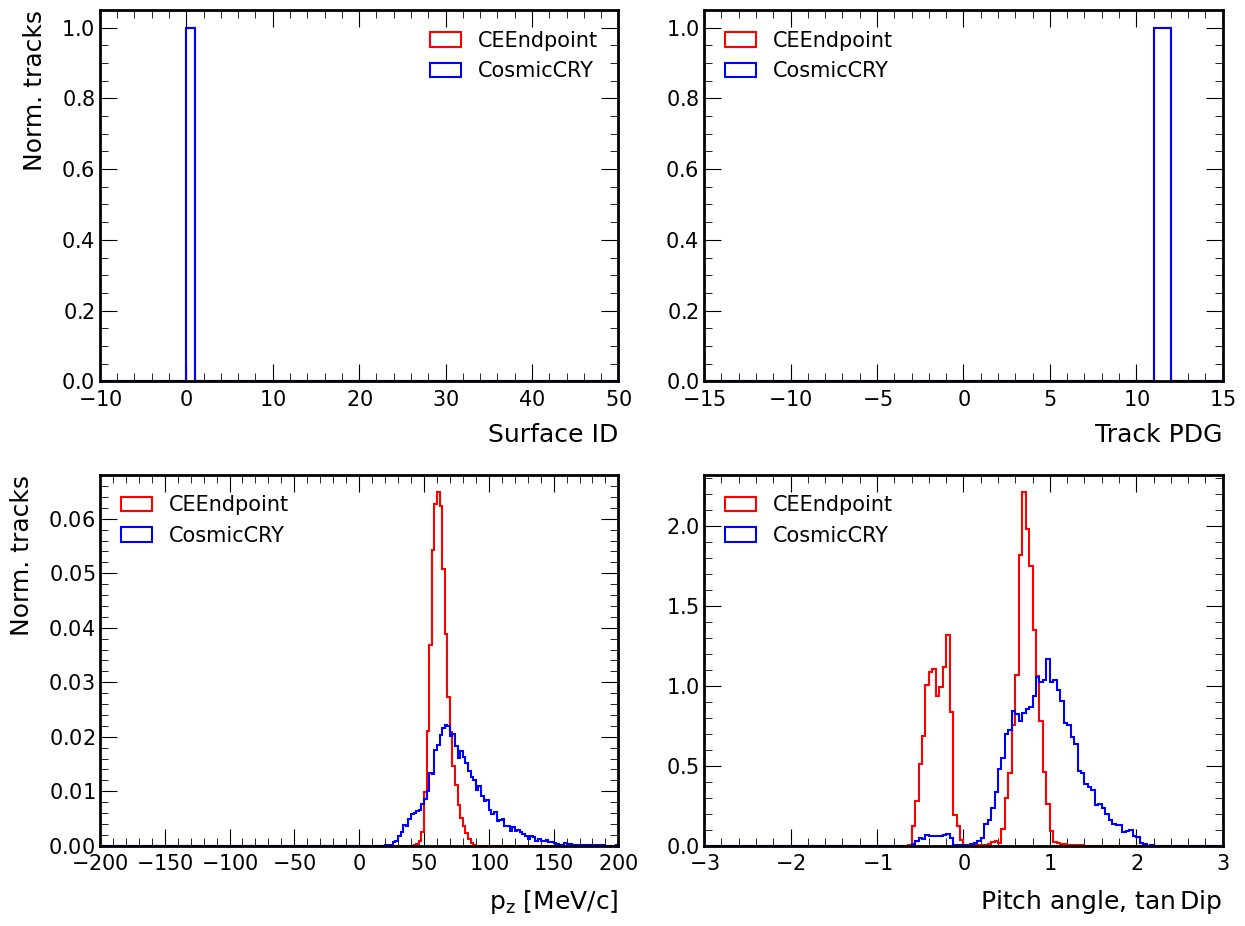

Wrote ../../img/comp/h1o_debug_tanDip.png


In [18]:
fig, ax = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))
print(len(ax))

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(signal["trkfit"]["trksegs"]["sid"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegs"]["sid"], axis=None)
    },
    nbins=60,xmin=-10,xmax=50,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax[0,0],
    xlabel=r"Surface ID",
    ylabel="Norm. tracks"
)

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(signal["trk"]["trk.pdg"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trk"]["trk.pdg"], axis=None)
    },
    nbins=30,xmin=-15,xmax=15,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax[0,1],
    xlabel=r"Track PDG",
    
)

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(signal["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"], axis=None)
    },
    nbins=200,xmin=-200,xmax=200,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ylabel="Norm. tracks",
    ax=ax[1,0],
    xlabel=r"$p_{z}$ [MeV/c]",
)

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None)
    },
    nbins=150,xmin=-3,xmax=3,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax[1,1],
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
)


plt.tight_layout()
out_path = f"../../img/comp/h1o_debug_tanDip.png"
# plt.title("title")
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Wrote {out_path}")

2


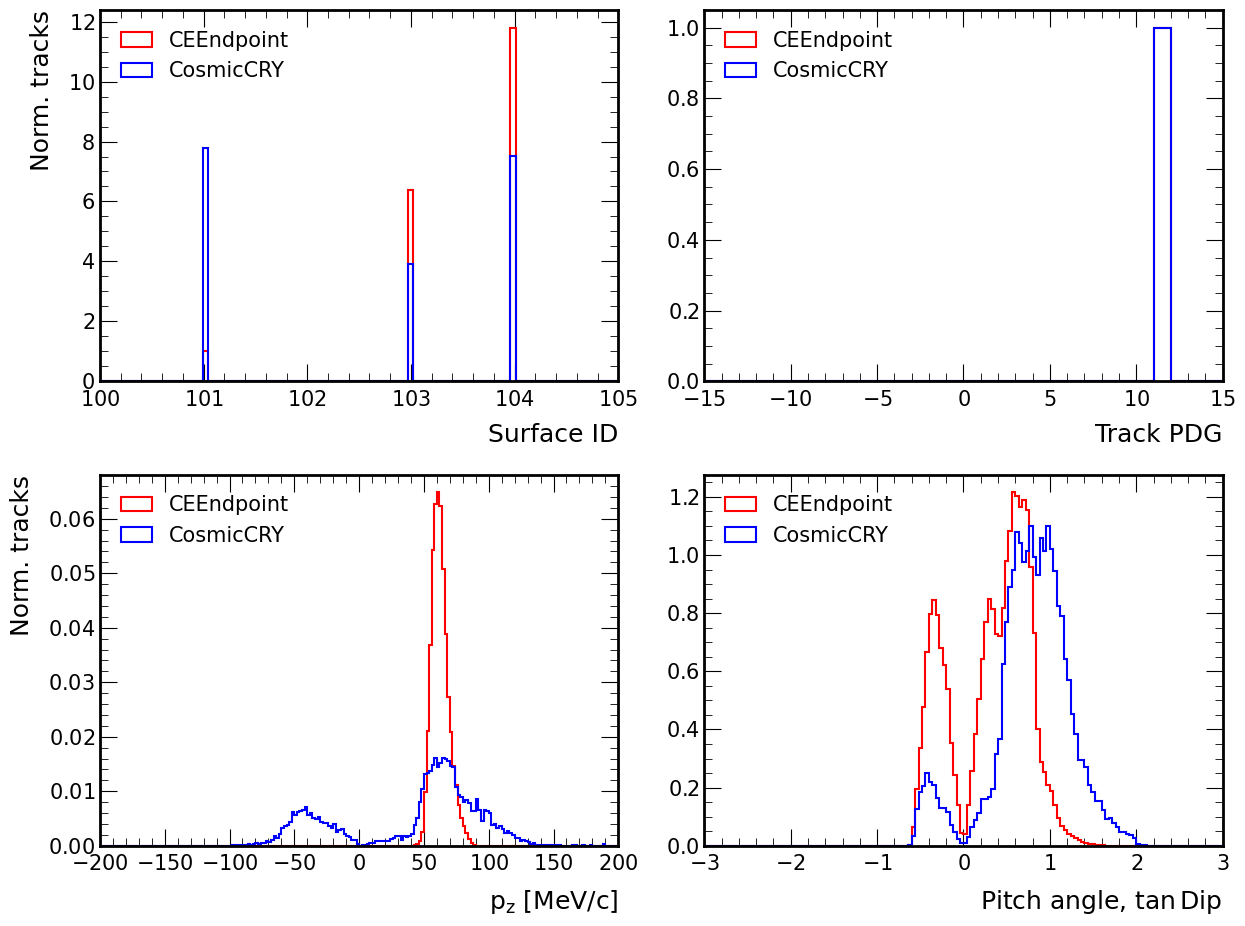

Wrote ../../img/comp/h1o_debug_tanDip_at_ST.png


In [19]:
fig, ax = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))
print(len(ax))

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(signal_at_ST["trkfit"]["trksegs"]["sid"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill_at_ST["trkfit"]["trksegs"]["sid"], axis=None)
    },
    nbins=96,xmin=100,xmax=105,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax[0,0],
    xlabel=r"Surface ID",
    ylabel="Norm. tracks"
)

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(signal_at_ST["trk"]["trk.pdg"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill_at_ST["trk"]["trk.pdg"], axis=None)
    },
    nbins=30,xmin=-15,xmax=15,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax[0,1],
    xlabel=r"Track PDG",
    
)

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(signal["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill_at_ST["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"], axis=None)
    },
    nbins=200,xmin=-200,xmax=200,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ylabel="Norm. tracks",
    ax=ax[1,0],
    xlabel=r"$p_{z}$ [MeV/c]",
)

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(signal_at_ST["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill_at_ST["trkfit"]["trksegpars_lh"]["tanDip"], axis=None)
    },
    nbins=150,xmin=-3,xmax=3,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax[1,1],
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
)


plt.tight_layout()
out_path = f"../../img/comp/h1o_debug_tanDip_at_ST.png"
# plt.title("title")
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Wrote {out_path}")

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


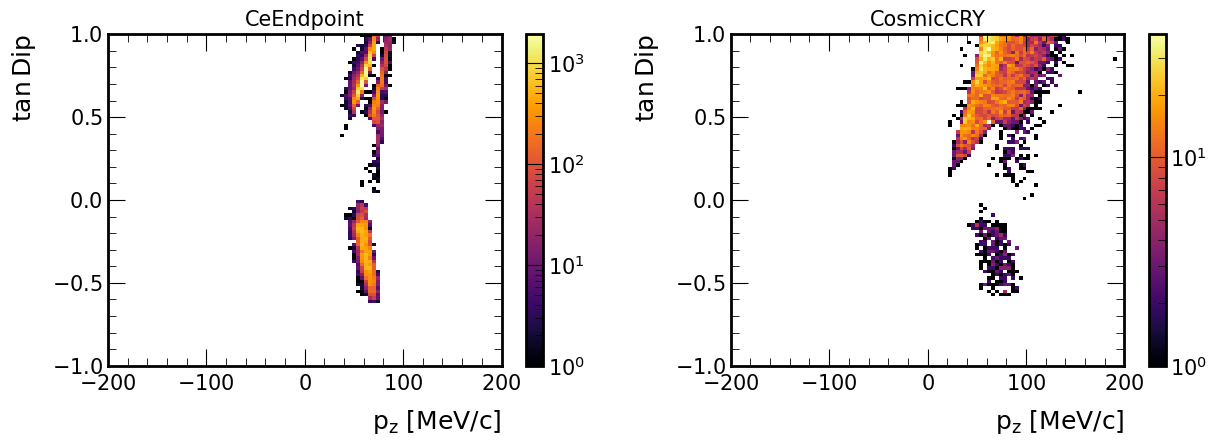

In [20]:
plotter=Plot()
# nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)
# nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

plotter.plot_2D(
    x=ak.flatten(signal["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"], axis=None),
    y=ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
    nbins_x=100,xmin=-200,xmax=200,
    nbins_y=100,ymin=-1,ymax=1,
    ax=ax[0],
    show=False,
    xlabel=r"$p_{z}$ [MeV/c]", 
    ylabel=r"$\tan{\text{Dip}}$",
    title="CeEndpoint",
    log_z=True
)

plotter.plot_2D(
    x=ak.flatten(onspill["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"], axis=None),
    y=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
    nbins_x=100,xmin=-200,xmax=200,
    nbins_y=100,ymin=-1,ymax=1,
    ax=ax[1],
    show=False,
    xlabel=r"$p_{z}$ [MeV/c]",
    ylabel=r"$\tan{\text{Dip}}$",
    title="CosmicCRY",
    log_z=True
)

# # ax.axvline(0.5577350, linestyle="--", color="grey")
# ax.axvline(2, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig(f"../../img/comp/h2_pz_vs_tanDip.png", dpi=300)
plt.show()


In [21]:
# !cat /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt | sort -V | head 

vector = Vector()

def calc_pitch_angle(data):

    pvec = vector.get_vector(data["trkfit"]["trksegs"], "mom")
    pt = np.sqrt(pvec["x"]**2 + pvec["y"]**2) # vector.get_vector(signal["trkfit"]["trksegs"], "mom")
    
    p = vector.get_mag(data["trkfit"]["trksegs"], "mom") 
    pz = data["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"]

    cos_theta = pt / p  
    theta = np.arccos(cos_theta)
    tan_theta_check = np.tan(theta)

    tan_theta = pz/pt # correct way!

    data["tan_theta"] = tan_theta
    data["tan_theta_check"] = tan_theta_check

calc_pitch_angle(signal)
calc_pitch_angle(onspill)

calc_pitch_angle(signal_at_ST)
calc_pitch_angle(onspill_at_ST)

# printer.print_n_events(signal, n_events=1)

[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


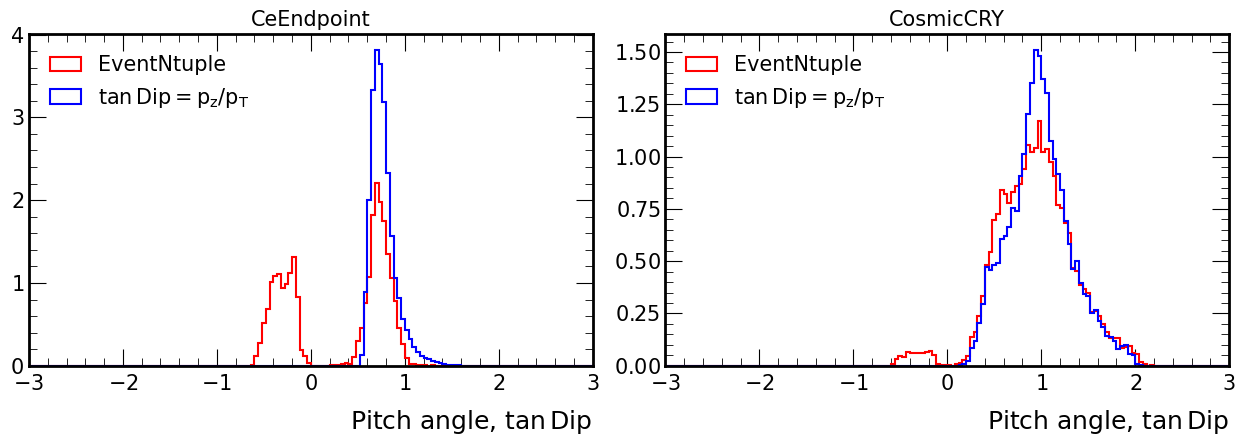

Wrote ../../img/comp/h1o_tanDip_calc.png


In [22]:
fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

plot.plot_1D_overlay(
    {
        "EventNtuple" : ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        r"$\tan{\text{Dip}} = p_{z}/p_{T}$" : ak.flatten(signal["tan_theta"], axis=None),
        # r"$\theta_{\text{Dip}} = p_{T}/p$" : ak.flatten(onspill["tan_theta_check"], axis=None)
    },
    nbins=150,xmin=-3,xmax=3,norm_by_area=True,
    show=False,
    title="CeEndpoint",
    ax=ax[0],
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
)

plot.plot_1D_overlay(
    {
        "EventNtuple" : ak.flatten(onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        r"$\tan{\text{Dip}} = p_{z}/p_{T}$" : ak.flatten(onspill["tan_theta"], axis=None),
        # r"$\theta_{\text{Dip}} = p_{T}/p$" : ak.flatten(onspill["tan_theta_check"], axis=None)
    },
    nbins=150,xmin=-3,xmax=3,norm_by_area=True,
    show=False,
    title="CosmicCRY",
    ax=ax[1],
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
)


plt.tight_layout()
out_path = f"../../img/comp/h1o_tanDip_calc.png"
# plt.title("title")
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Wrote {out_path}")

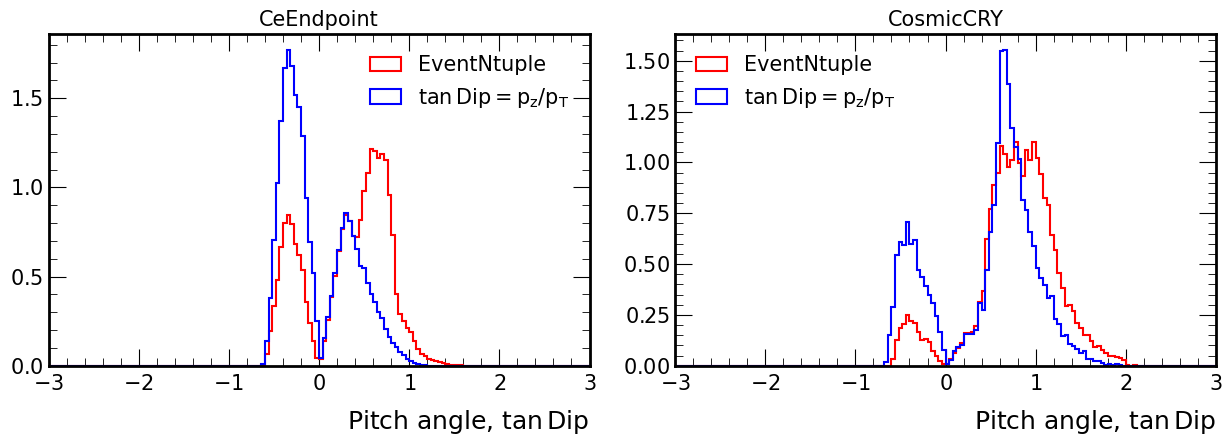

Wrote ../../img/comp/h1o_tanDip_at_ST_calc.png


In [23]:
fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

plot.plot_1D_overlay(
    {
        "EventNtuple" : ak.flatten(signal_at_ST["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        r"$\tan{\text{Dip}} = p_{z}/p_{T}$" : ak.flatten(signal_at_ST["tan_theta"], axis=None),
        # r"$\theta_{\text{Dip}} = p_{T}/p$" : ak.flatten(onspill["tan_theta_check"], axis=None)
    },
    nbins=150,xmin=-3,xmax=3,norm_by_area=True,
    show=False,
    title="CeEndpoint",
    ax=ax[0],
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
)

plot.plot_1D_overlay(
    {
        "EventNtuple" : ak.flatten(onspill_at_ST["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        r"$\tan{\text{Dip}} = p_{z}/p_{T}$" : ak.flatten(onspill_at_ST["tan_theta"], axis=None),
        # r"$\theta_{\text{Dip}} = p_{T}/p$" : ak.flatten(onspill["tan_theta_check"], axis=None)
    },
    nbins=150,xmin=-3,xmax=3,norm_by_area=True,
    show=False,
    title="CosmicCRY",
    ax=ax[1],
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
)


plt.tight_layout()
out_path = f"../../img/comp/h1o_tanDip_at_ST_calc.png"
# plt.title("title")
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Wrote {out_path}")

## Does the dip angle depend on SID at all? Is it just being broadcast to "all" 

[pyvector] ⭐️ Initialised Vector with verbosity = 1


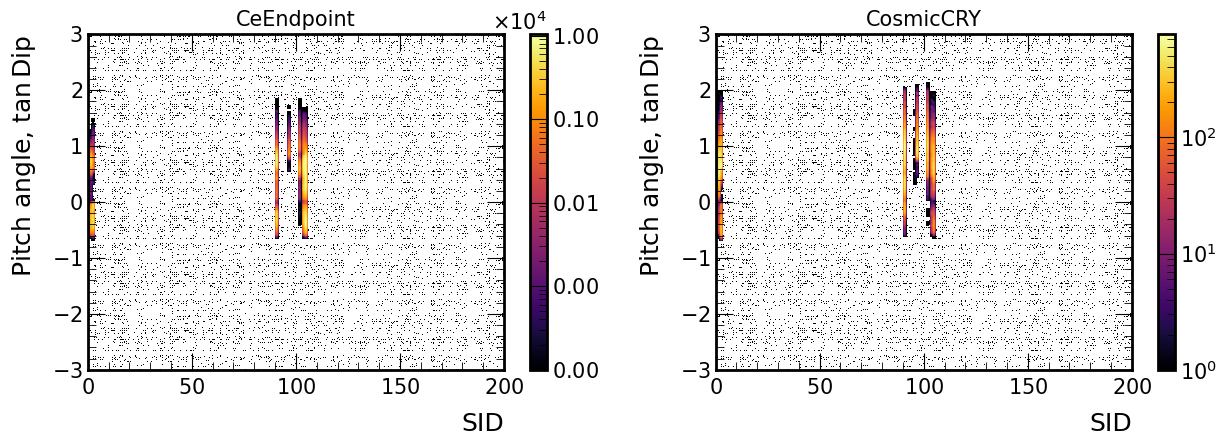

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

vector = Vector()

plotter.plot_2D(
    x=ak.flatten(data_signal["trkfit"]["trksegs"]["sid"], axis=None),
    y=ak.flatten(data_signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
    nbins_x=200,xmin=0,xmax=200,
    nbins_y=150,ymin=-3,ymax=3,
    ax=ax[0],
    show=False,
    xlabel="SID", 
    ylabel=r"Pitch angle, $\tan{\text{Dip}}$",
    title="CeEndpoint",
    log_z=True
    # norm=True
)

plotter.plot_2D(
    x=ak.flatten(data_onspill["trkfit"]["trksegs"]["sid"], axis=None),
    y=ak.flatten(data_onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
    nbins_x=200,xmin=0,xmax=200,
    nbins_y=150,ymin=-3,ymax=3,
    ax=ax[1],
    show=False,
    xlabel=f"SID", 
    ylabel=r"Pitch angle, $\tan{\text{Dip}}$",
    title="CosmicCRY",
    # norm=True
    log_z=True
)

# # ax.axvline(0.5577350, linestyle="--", color="grey")
# ax.axvline(2, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig(f"../../img/comp/h2_SID_vs_tanDip_{tag}.png", dpi=300)
plt.show()

In [25]:
# # ONE TRACK

# printer = Print(verbose=True)

# printer.print_n_events(data_signal, n_events=10)

[pyvector] ⭐️ Initialised Vector with verbosity = 1


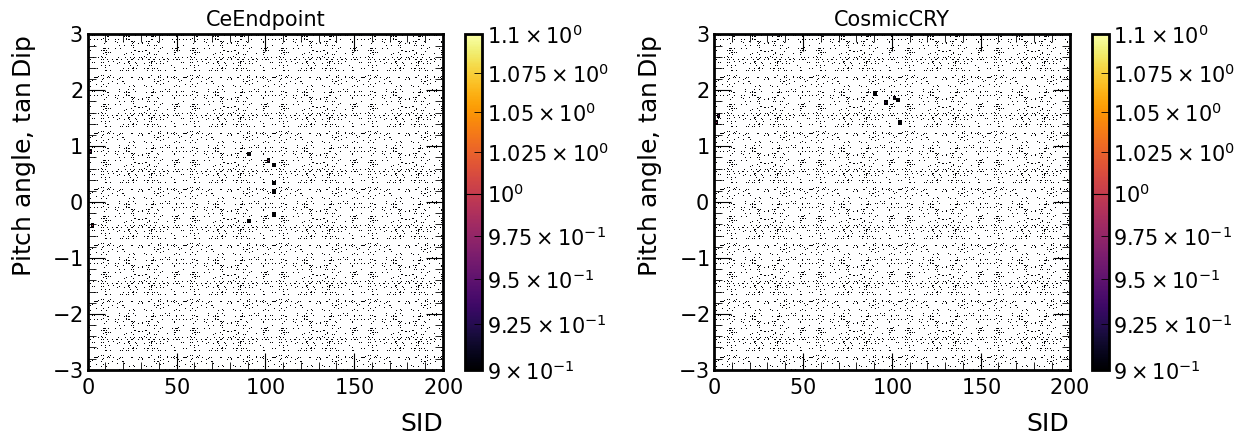

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

vector = Vector()

plotter.plot_2D(
    x=ak.flatten(data_signal["trkfit"]["trksegs"]["sid"][0], axis=None),
    y=ak.flatten(data_signal["trkfit"]["trksegpars_lh"]["tanDip"][0], axis=None),
    nbins_x=200,xmin=0,xmax=200,
    nbins_y=150,ymin=-3,ymax=3,
    ax=ax[0],
    show=False,
    xlabel="SID", 
    ylabel=r"Pitch angle, $\tan{\text{Dip}}$",
    title="CeEndpoint",
    log_z=True
    # norm=True
)

plotter.plot_2D(
    x=ak.flatten(data_onspill["trkfit"]["trksegs"]["sid"][0], axis=None),
    y=ak.flatten(data_onspill["trkfit"]["trksegpars_lh"]["tanDip"][0], axis=None),
    nbins_x=200,xmin=0,xmax=200,
    nbins_y=150,ymin=-3,ymax=3,
    ax=ax[1],
    show=False,
    xlabel=f"SID", 
    ylabel=r"Pitch angle, $\tan{\text{Dip}}$",
    title="CosmicCRY",
    # norm=True
    log_z=True
)

# # ax.axvline(0.5577350, linestyle="--", color="grey")
# ax.axvline(2, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig(f"../../img/comp/h2_SID_vs_tanDip_{tag}_one_event.png", dpi=300)
plt.show()

## d_0 vs mom

In [27]:
# help(plot.plot_2D)

In [28]:
vector = Vector()
pvec = vector.get_vector(signal["trkfit"]["trksegs"], "mom")
p_T = pvec.mag
# p_T = pvec.pt
# import vector
print(pvec["x"])

[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[[[-12.5]], [[-67.9]], [[2.68]], [[-87.2]], ..., [[18.8]], [[66.8]], [[73.8]]]


In [29]:
print(list(set(ak.flatten(data_onspill["trkfit"]["trksegs"]["sid"], axis=None))))
print(list(set(ak.flatten(data_signal["trkfit"]["trksegs"]["sid"], axis=None))))

[96, 0, 1, 2, 101, 103, 104, 90, 95]
[0, 1, 2, 96, 101, 103, 104, 90]


In [30]:
# help(plot.plot_1D_overlay)

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


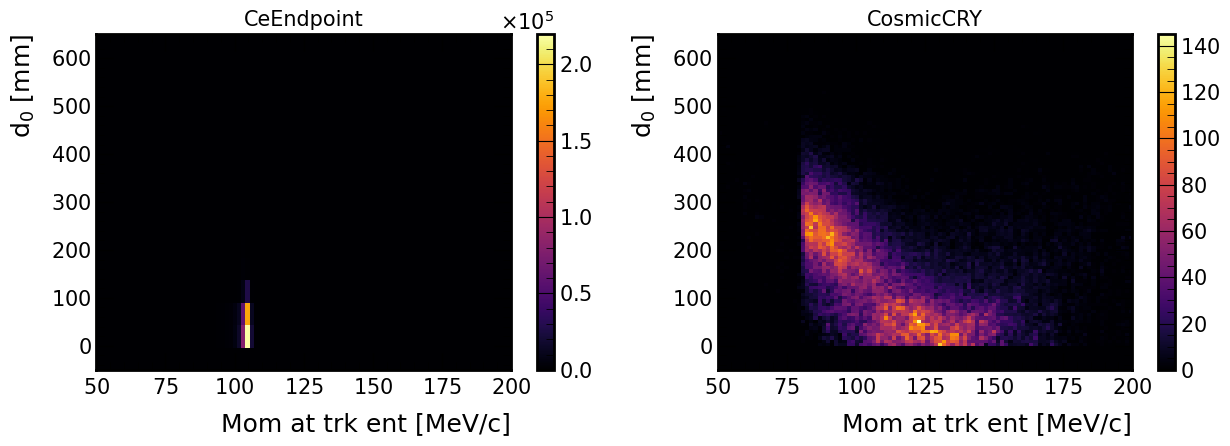

In [31]:
plotter=Plot()
# nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)
# nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

vector = Vector()

plotter.plot_2D(
    x=ak.flatten(vector.get_mag(data_signal["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(data_signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=15,ymin=-50,ymax=650,
    ax=ax[0],
    show=False,
    xlabel=r"Mom at trk ent [MeV/c]", 
    ylabel=r"$d_{0}$ [mm]",
    title="CeEndpoint",
    # norm=True
)

plotter.plot_2D(
    x=ak.flatten(vector.get_mag(data_onspill["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(data_onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=100,ymin=-50,ymax=650,
    ax=ax[1],
    show=False,
    xlabel=r"Mom at trk ent [MeV/c]", 
    ylabel=r"$d_{0}$ [mm]",
    title="CosmicCRY",
    # norm=True
    # log_z=True
)

# # ax.axvline(0.5577350, linestyle="--", color="grey")
# ax.axvline(2, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig(f"../../img/comp/h2_mom_vs_d0_{tag}.png", dpi=300)
plt.show()

# tanDip

what is the relationship with track z-momentum 

[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


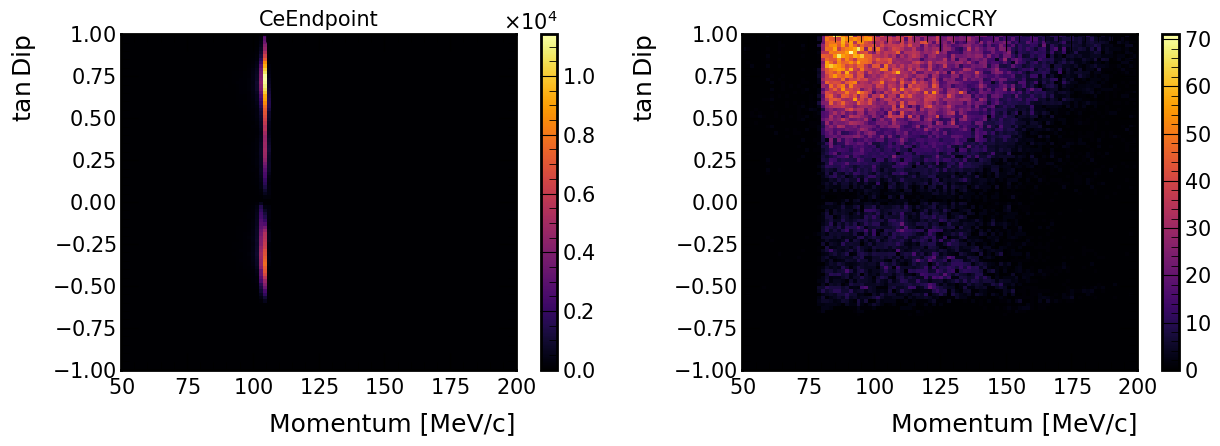

In [32]:
# plot=Plot()
# nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)
# nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

plotter.plot_2D(
    x=ak.flatten(vector.get_mag(data_signal["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(data_signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=100,ymin=-1,ymax=1,
    ax=ax[0],
    show=False,
    xlabel=r"Momentum [MeV/c]", 
    ylabel=r"$\tan{\text{Dip}}$",
    title="CeEndpoint",
    log_z=False
)

plotter.plot_2D(
    x=ak.flatten(vector.get_mag(data_onspill["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(data_onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=100,ymin=-1,ymax=1,
    ax=ax[1],
    show=False,
    xlabel=r"Momentum [MeV/c]",
    ylabel=r"$\tan{\text{Dip}}$",
    title="CosmicCRY",
    log_z=False
)

# # ax.axvline(0.5577350, linestyle="--", color="grey")
# ax.axvline(2, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig(f"../../img/comp/h2_mom_vs_tanDip.png", dpi=300)
plt.show()


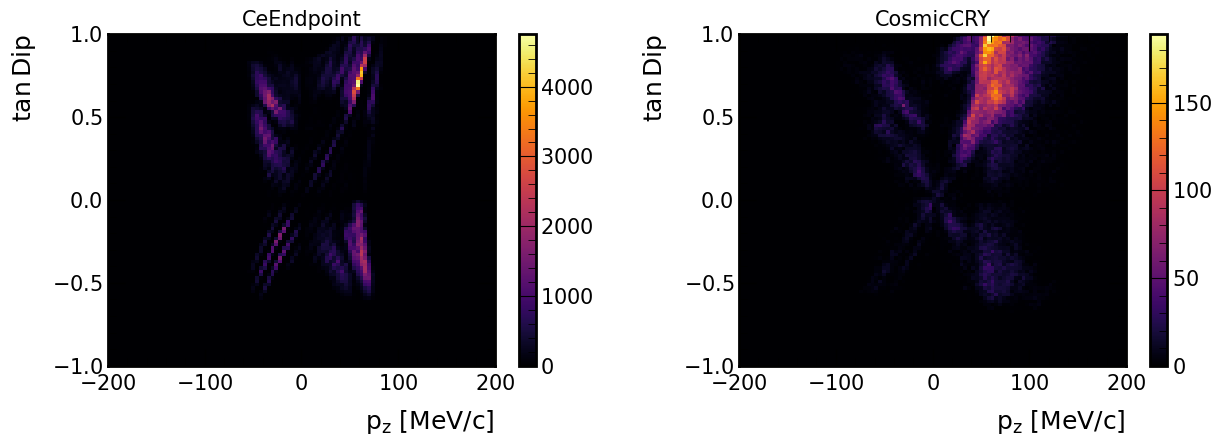

In [33]:
# plot=Plot()
# nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)
# nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

plotter.plot_2D(
    x=ak.flatten(data_signal["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"], axis=None),
    y=ak.flatten(data_signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
    nbins_x=100,xmin=-200,xmax=200,
    nbins_y=100,ymin=-1,ymax=1,
    ax=ax[0],
    show=False,
    xlabel=r"$p_{z}$ [MeV/c]", 
    ylabel=r"$\tan{\text{Dip}}$",
    title="CeEndpoint",
    log_z=False
)

plotter.plot_2D(
    x=ak.flatten(data_onspill["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"], axis=None),
    y=ak.flatten(data_onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
    nbins_x=100,xmin=-200,xmax=200,
    nbins_y=100,ymin=-1,ymax=1,
    ax=ax[1],
    show=False,
    xlabel=r"$p_{z}$ [MeV/c]",
    ylabel=r"$\tan{\text{Dip}}$",
    title="CosmicCRY",
    log_z=False
)

# # ax.axvline(0.5577350, linestyle="--", color="grey")
# ax.axvline(2, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig(f"../../img/comp/h2_pz_vs_tanDip.png", dpi=300)
plt.show()
